### <center>Camada Silver e Gold</center>

--------

#### Bibliotecas

In [1]:
from minio import Minio
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Variáveis Locais

In [2]:
# Variáveis MinIO
MINIO_ENDPOINT = "localhost:9000"
MINIO_ACCESS_KEY = "minio"
MINIO_SECRET_KEY = "minio123"
BUCKET_NAME = "xau-lake"

#### Validando a Existência do Bucket

In [3]:
# Selecionando o Timeframe que utilizaremos inicialmente
TIMEFRAME = "1d"

In [4]:
client = Minio(
    MINIO_ENDPOINT,
    access_key=MINIO_ACCESS_KEY,
    secret_key=MINIO_SECRET_KEY,
    secure=False,
)

In [5]:
if not client.bucket_exists(BUCKET_NAME):
    raise RuntimeError(f"Bucket {BUCKET_NAME} não existe. Crie antes no 01_download_raw.")
else:
    print(f"Bucket '{BUCKET_NAME}' encontrado.")

Bucket 'xau-lake' encontrado.


#### Lendo dados Parquet da Silver

In [6]:
silver_key = f"silver/timeframe={TIMEFRAME}/XAU_{TIMEFRAME}_data.parquet"
print("Lendo:", silver_key)

Lendo: silver/timeframe=1d/XAU_1d_data.parquet


In [7]:
response = client.get_object(BUCKET_NAME, silver_key)
data_bytes = response.read()
response.close()
response.release_conn()

In [8]:
df = pd.read_parquet(BytesIO(data_bytes))

In [9]:
print("Shape:", df.shape)

Shape: (5440, 7)


In [10]:
df.head()

,timestamp,open,high,low,close,volume,timeframe
0,2004-06-11,384.0,384.8,382.8,384.1,272,1d
1,2004-06-14,384.3,385.8,381.8,382.8,1902,1d
2,2004-06-15,382.8,388.8,381.1,388.6,1951,1d
3,2004-06-16,387.1,389.8,382.6,383.8,2014,1d
4,2004-06-17,383.6,389.3,383.0,387.6,1568,1d


#### EDA Básico

In [11]:
# Garantindo ordenação
df = df.sort_values("timestamp")

In [12]:
# Retorno simples diário (ex.: 0.01 = 1%)
df["return"] = df["close"].pct_change()

In [13]:
# Retorno logarítmico (útil pra algumas análises)
df["log_return"] = np.log(df["close"]).diff()

In [14]:
# Retorno acumulado ao longo do tempo
df["cum_return"] = (1 + df["return"]).cumprod() - 1

In [15]:
# Médias móveis de 20 e 50 dias
df["ma20"] = df["close"].rolling(20).mean()
df["ma50"] = df["close"].rolling(50).mean()

In [16]:
# Volatilidade (desvio padrão dos retornos) em janela de 20 dias
df["vol20"] = df["return"].rolling(20).std()

In [17]:
print(df.dtypes)

timestamp     datetime64[ns]
open                 float64
high                 float64
low                  float64
close                float64
volume                 int64
timeframe             object
return               float64
log_return           float64
cum_return           float64
ma20                 float64
ma50                 float64
vol20                float64
dtype: object


In [18]:
df.tail()

,timestamp,open,high,low,close,volume,timeframe,return,log_return,cum_return,ma20,ma50,vol20
5435,2025-09-25,3736.80,3761.72,3721.75,3748.82,443032,1d,0.003480,0.003474,8.760010,3633.4250,3468.1710,0.007597
5436,2025-09-26,3749.85,3783.77,3734.50,3760.10,392151,1d,0.003009,0.003004,8.789378,3649.0650,3476.3800,0.007530
5437,2025-09-29,3759.47,3834.05,3756.58,3833.28,494753,1d,0.019462,0.019275,8.979901,3666.9120,3485.1154,0.008215
5438,2025-09-30,3832.81,3871.61,3792.98,3858.15,522111,1d,0.006488,0.006467,9.044650,3683.2035,3493.6834,0.007798
5439,2025-10-01,3859.31,3875.57,3854.53,3865.88,47836,1d,0.002004,0.002002,9.064775,3698.5530,3503.2546,0.007781


#### Salvando os Dados Transformados - Camada Gold

In [19]:
gold_key = f"gold/timeframe={TIMEFRAME}/XAU_{TIMEFRAME}_features.parquet"

In [20]:
buffer = BytesIO()
df.to_parquet(buffer, index=False)
buffer.seek(0)

0

In [21]:
client.put_object(
    BUCKET_NAME,
    gold_key,
    data=buffer,
    length=buffer.getbuffer().nbytes,
    content_type="application/octet-stream",
)

ObjectWriteResult(bucket_name='xau-lake', object_name='gold/timeframe=1d/XAU_1d_features.parquet', version_id=None, etag='882b7ef05309a92bf0bf6bdc125fc971', http_headers=HTTPHeaderDict({'Accept-Ranges': 'bytes', 'Content-Length': '0', 'ETag': '"882b7ef05309a92bf0bf6bdc125fc971"', 'Server': 'MinIO', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'Vary': 'Origin, Accept-Encoding', 'X-Amz-Id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8', 'X-Amz-Request-Id': '187A7746B4D92099', 'X-Content-Type-Options': 'nosniff', 'X-Ratelimit-Limit': '6452', 'X-Ratelimit-Remaining': '6452', 'X-Xss-Protection': '1; mode=block', 'Date': 'Sat, 22 Nov 2025 23:15:49 GMT'}), last_modified=None, location=None)

In [22]:
print("Arquivo Gold enviado para:", gold_key)

Arquivo Gold enviado para: gold/timeframe=1d/XAU_1d_features.parquet


In [23]:
for obj in client.list_objects(BUCKET_NAME, prefix="gold/timeframe=1d/", recursive=True):
    print(obj.object_name, "-", obj.size, "bytes")

gold/timeframe=1d/XAU_1d_features.parquet - 503218 bytes


#### Gráficos

In [24]:
sns.set(style="whitegrid")

In [25]:
# Filtrar a partir de 2010 para ficar mais legível
df_cum = df[df["timestamp"] >= "2010-01-01"]

##### Gráfico de Retorno Acumulado

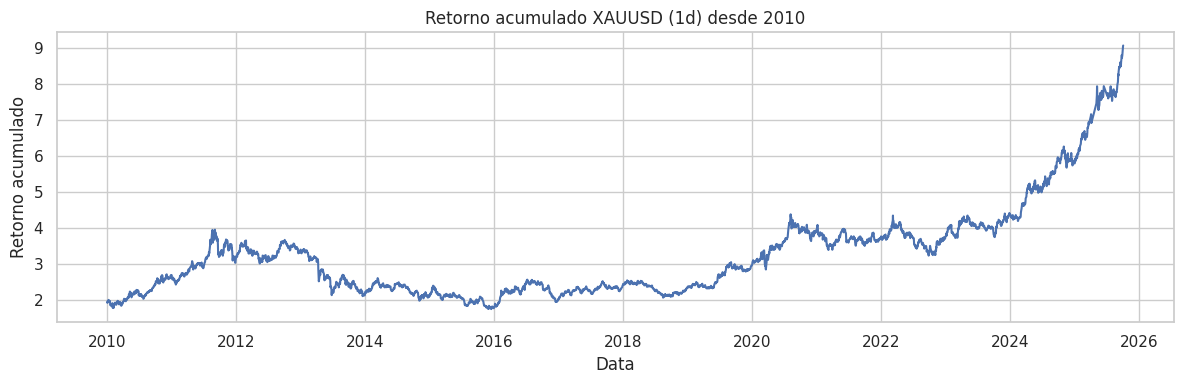

In [26]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_cum, x="timestamp", y="cum_return")
plt.title("Retorno acumulado XAUUSD (1d) desde 2010")
plt.xlabel("Data")
plt.ylabel("Retorno acumulado")
plt.tight_layout()
plt.show()

##### Histograma de Retornos Diários

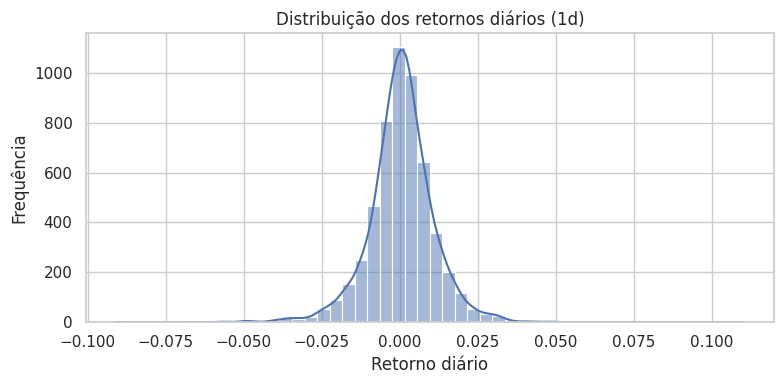

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(df["return"].dropna(), bins=50, kde=True)
plt.title("Distribuição dos retornos diários (1d)")
plt.xlabel("Retorno diário")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()